In [1]:
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from scipy.sparse import hstack
import random

In [2]:
real_df = pd.read_csv('/content/Fake.csv', encoding='ISO-8859-1', on_bad_lines='skip')
fake_df = pd.read_csv('/content/True.csv', encoding='ISO-8859-1', on_bad_lines='skip')

FileNotFoundError: ignored

In [3]:
real_df.info()

NameError: ignored

In [4]:
fake_df.info()

NameError: ignored

In [ ]:
list(real_df.sample(5).title)

[' China Drone Drama Was Over Before Trumpâ\x80\x99s First Tweet â\x80\x93 If He Got Intel Briefings Heâ\x80\x99d Have Known It',
 ' Loan Officer Fired From Her Job After Posting A HORRIBLY Racist Tweet About Michelle Obama',
 'WOMEN IN FRANCE Fight Back After Muslim Men BAN Them From Sharing Public Spaces [VIDEO]',
 'BILL Oâ\x80\x99REILLY IS OUT At Fox News Over Alleged Sexual Remarks, Advancesâ\x80¦Evidence Of â\x80\x9cSmear Campaignâ\x80\x9d By â\x80\x9cFar-Leftâ\x80\x9d Has Been Uncovered',
 'PUERTO RICO: Local Cop Calls US Radio Station Tells Shocking Reason Aid Isnâ\x80\x99t Getting To People [Video]']

In [ ]:
list(real_df.sample(1).text)

['If you tuned into the first presidential debate last night, you already know that Hillary Clinton pretty much wiped the floor with Donald Trump. Trump was so nervous and unprepared that he was reduced to constant sniffling, excessive thirstiness and his usual outlandish rants and interruptions. Let s just say that everyone noticed.Trump couldn t take the heat, and he definitely cannot handle the humiliation that is following the debate. While several major media outlets are calling the debate a clear win for Clinton, Trump is trying to come up with reasons why he bombed so horribly (even though it was perfectly obvious that he would).The best excuse Trump has been able to come up with is beyond pathetic and nothing but a move of desperation. The Associated Press has reported that after the debate, the GOP nominee immediately told reporters that he was unable to perform to the best of his ability because there was something wrong with his microphone. And yet despite something being  w

In [ ]:
list(fake_df.sample(5).title)

['Iran tests new missile after U.S. criticizes arms program',
 'Clinton email problem resurfaces as FBI announces review',
 'Kremlin: accusations that Russia behind Kiev blast are "baseless"',
 'Greece debates bill on legal gender change, divisions laid bare',
 "Clinton: Senate should consider Obama's high court pick 'immediately'"]

In [ ]:
list(fake_df.sample(1).text)

['HOUSTON/WASHINGTON (Reuters) - The top executive at the company behind the embattled Dakota Access Pipeline has donated more than $100,000 to Republican presidential candidate Donald Trump since June, according to campaign finance disclosure records. The donations by Kelcy Warren, chairman and chief executive officer at pipeline operator Energy Transfer Partners, support the candidate seen by many as more likely to promote the U.S. oil and gas industry than his opponent, Democrat Hillary Clinton. Warren donated $300 to the Trump campaign during the primaries, and $2,700 to Trump during the general election phase of the campaign, for the maximum contribution allowed by a single individual during an election.  He also gave $100,000 to the Trump Victory Fund, a joint fundraising committee that includes the Trump campaign, the Republican National Committee, the Republican Party of Arkansas and the Connecticut Republican Party.  The donations, first reported by the British newspaper The G

In [ ]:
real_df['Fake_news'] = 0
fake_df['Fake_news'] = 1

# Data visualization

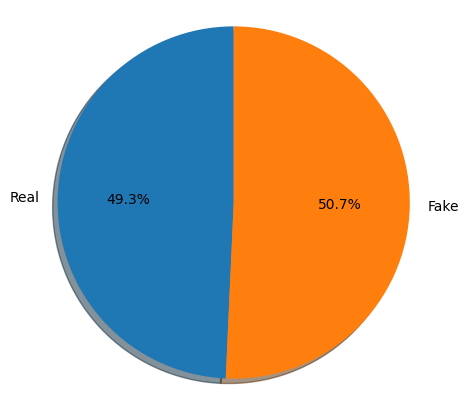

In [ ]:
fig = plt.figure(figsize=(5, 5))
labels = 'Real', 'Fake'
sizes = [len(real_df), len(fake_df)]

plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')
plt.show()

In [ ]:
positive_titles = np.array(real_df.title)
negative_titles = np.array(fake_df.title)

In [ ]:
import re

def process_news(news):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    news = re.sub(r'https?://[^\s\n\r]+', '', news)
    news = re.sub(r'[^a-zA-Z\s]', '', news)

    news_tokens = word_tokenize(news)

    news_clean = []
    for word in news_tokens:
        if (word not in stopwords_english and
                word not in string.punctuation):

            stem_word = stemmer.stem(word)
            news_clean.append(stem_word)

    return news_clean

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
rand_id = random.randint(0,len(positive_titles))
print(positive_titles[rand_id],process_news(positive_titles[rand_id]))

CHURCHGOERS TRAPPED INSIDE CATHEDRAL After Man Hits Police Officer Guarding Church In Head With Hammerâ¦Authorities Calling It Act Of Terror [VIDEO] ['churchgoer', 'trap', 'insid', 'cathedr', 'after', 'man', 'hit', 'polic', 'offic', 'guard', 'church', 'in', 'head', 'with', 'hammerauthor', 'call', 'it', 'act', 'of', 'terror', 'video']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
news_title = np.concatenate((positive_titles, negative_titles), axis=0)

In [ ]:
positive_y = np.array(real_df.Fake_news)
negative_y = np.array(fake_df.Fake_news)
y = np.concatenate((positive_y, negative_y), axis=0)

# Splitting dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(news_title, y, test_size=0.20, random_state=0)

In [ ]:
def build_freqs(news, ys):
    yslist = np.squeeze(ys).tolist()
    freqs = {}
    for y, new in zip(yslist, news):
        for word in process_news(new):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

#Training model

In [ ]:
freqs = build_freqs(news_title, y)

In [ ]:
def train_naive_bayes(freqs, train_x, train_y):
    loglikelihood = {}
    logprior = 0

    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    N_pos = N_neg = 0
    for pair in freqs.keys():

        if pair[1] > 0:
            N_pos += freqs[pair]
        else:
            N_neg += freqs[pair]


    D = len(train_y)

    D_pos = np.sum((train_y == 1))

    D_neg = np.sum((train_y == 0))

    logprior = np.log(D_pos) - np.log(D_neg)

    for word in vocab:
        freq_pos = freqs.get((word,1),0)
        freq_neg = freqs.get((word,0),0)

        p_w_pos = (freq_pos + 1)/(N_pos +V)
        p_w_neg = (freq_neg + 1)/(N_neg +V)

        loglikelihood[word] = np.log(p_w_pos) - np.log(p_w_neg)

    return logprior, loglikelihood

In [ ]:
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)

# Prediction and accuracy

In [ ]:
def naive_bayes_predict(news, logprior, loglikelihood):
    word_l = process_news(news)
    p = 0
    p += logprior

    for word in word_l:
        if word in loglikelihood:
            p += loglikelihood[word]

    return p

In [ ]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood, naive_bayes_predict=naive_bayes_predict):
    accuracy = 0

    y_hats = []
    for new in test_x:
        if naive_bayes_predict(new, logprior, loglikelihood) > 0:
            y_hat_i = 1
        else:
            y_hat_i = 0
        y_hats.append(y_hat_i)

    error = np.sum((y_hats != test_y))/len(test_y)

    accuracy = 1 - error

    return accuracy

In [ ]:
test_naive_bayes(X_test, y_test, logprior, loglikelihood)

0.9828949073474148

In [ ]:
rand_id = random.randint(0,len(X_test))
Value_predict = 'Fake' if naive_bayes_predict(X_test[rand_id], logprior, loglikelihood) > 0 else 'Real'
assigned_value = 'Fake' if y_test[rand_id] == 1 else 'Real'
print(X_test[rand_id], 'Predicted: ', Value_predict, '; Assigned value:', assigned_value)

U.S. senators to introduce bill to secure 'internet of things' Predicted:  Fake ; Assigned value: Fake
